In [1]:
# Custom classes
from pandasgui import show
from Library.DFInfo import DataFrameInfo
from Library.db_util import RDSDatabaseConnector
from Library.GraphPlotter import Plotter
from Library.DFTransform import DataFrameTransform
from Library.DTransform import DataTransform
from Library.DFInsights import Insights

# modules
import warnings, os
import pandas as pd

# to stop spam of deprecated feature
warnings.simplefilter(action="ignore", category=FutureWarning) 

#creates all the classes
rdsdbc = RDSDatabaseConnector()
dtransformer = DataTransform()
dfinfo = DataFrameInfo()
dftransformer = DataFrameTransform()
plotter = Plotter()
insights = Insights()

available_list = ["policy_code"]
string_list = ["policy_code", "term"]
strip_list = ["term"]
qualitative_list = ["purpose", "grade", "sub_grade","home_ownership", "verification_status", "loan_status", "payment_plan", "application_type", "employment_length"]
outlier_columns = ["funded_amount", "funded_amount_inv", "installment", "open_accounts", "delinq_2yrs", "total_accounts", "total_payment", "total_payment_inv", "total_rec_prncp", "total_rec_int", "last_payment_amount"]
ignore_transform_list = ["funded_amount", "funded_amount_inv"]

dtransformer.set_available_list(available_list)
dtransformer.set_string_list(string_list)
dtransformer.set_strip_list(strip_list)
dtransformer.set_qualitative_list(qualitative_list)

file_path = "script_data/loan_payments.csv"

try:
    dataframe = pd.read_csv(file_path)
    print("loaded from file")
except:
    dataframe = rdsdbc.download_df()
    print("downloaded dataframe")


loaded from file


We will use our ```dfinfo``` Module to get all relevant information on this dataset. From there, we can see what needs to be done.

In [2]:
dfinfo.call_all_information(dataframe)

         Unnamed: 0            id     member_id   loan_amount  funded_amount  \
count  54231.000000  5.423100e+04  5.423100e+04  54231.000000   51224.000000   
mean   27115.000000  7.621797e+06  8.655350e+06  13333.076100   13229.509117   
std    15655.285561  9.571362e+06  1.031281e+07   8082.196709    8019.017599   
min        0.000000  5.552100e+04  7.069400e+04    500.000000     500.000000   
50%    27115.000000  7.084590e+06  8.709873e+06  12000.000000   12000.000000   
max    54230.000000  3.867612e+07  4.146185e+07  35000.000000   35000.000000   

       funded_amount_inv      int_rate    instalment    annual_inc  \
count       54231.000000  49062.000000  54231.000000  5.423100e+04   
mean        12952.622979     13.507328    400.013953  7.222085e+04   
std          8099.473527      4.392893    238.920012  5.158934e+04   
min             0.000000      5.420000     15.670000  3.300000e+03   
50%         11300.000000     13.160000    347.150000  6.100000e+04   
max         35000.0

In [3]:
dataframe = dtransformer.call_all_cleaners(dataframe)

Columns with skewness greater than 5 are: ['annual_inc', 'delinq_2yrs', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'collections_12_mths_ex_med']


PandasGUI INFO — pandasgui.gui — Opening PandasGUI


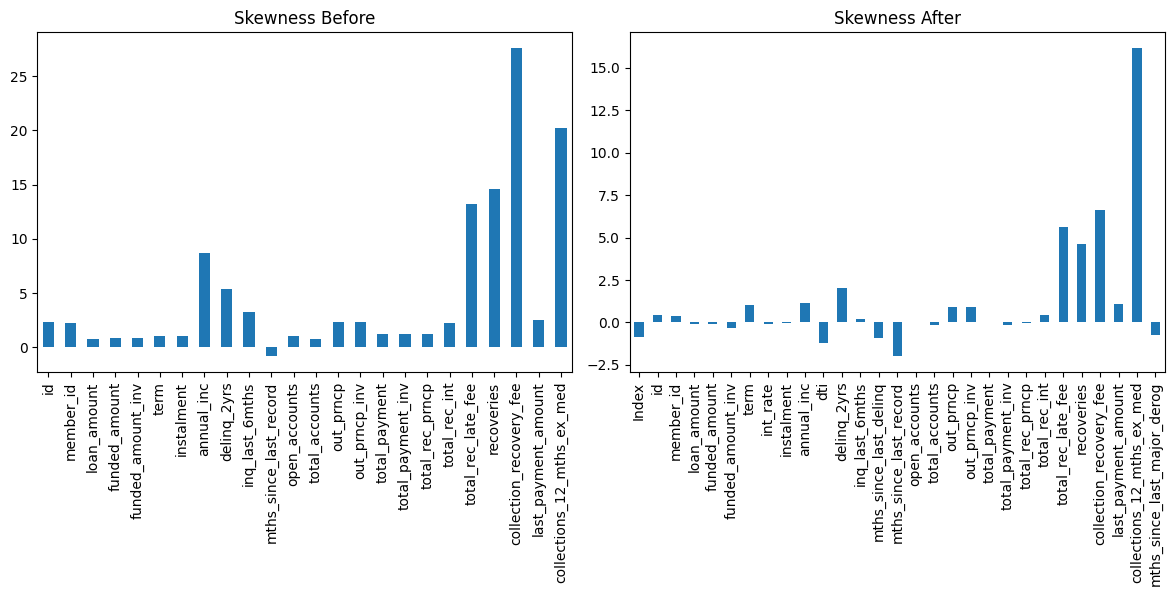

In [4]:
skewed_columns = dtransformer.get_skewed_columns(dataframe, qualitative_list, 0.5)
skewed_dataframe, median_list = dtransformer.get_skewed_dataframe(dataframe, skewed_columns)
unskewed_dataframe, transformation_methods = dftransformer.remove_skewness(dataframe, qualitative_list)
plotter.plot_skewed_vs_unskewed_graph(skewed_dataframe.skew(), unskewed_dataframe.skew())

In [5]:
print(f"These are all the transformation methods done on each column: \n \n{transformation_methods}")

These are all the transformation methods done on each column: 
 
Transformed column 'Index'using transformation method: None,  
Transformed column 'id'using transformation method: log,  
Transformed column 'member_id'using transformation method: log,  
Transformed column 'loan_amount'using transformation method: cbrt,  
Transformed column 'funded_amount'using transformation method: cbrt,  
Transformed column 'funded_amount_inv'using transformation method: sqrt,  
Transformed column 'term'using transformation method: cbrt,  
Transformed column 'int_rate'using transformation method: sqrt,  
Transformed column 'instalment'using transformation method: cbrt,  
Transformed column 'annual_inc'using transformation method: log,  
Transformed column 'dti'using transformation method: None,  
Transformed column 'delinq_2yrs'using transformation method: cbrt,  
Transformed column 'inq_last_6mths'using transformation method: cbrt,  
Transformed column 'mths_since_last_delinq'using transformation met

from this function above, we can see ```collection_recovery_fee```, ```collections_12_mths_ex_med```, ```recoveries```, ```total_rec_late_fee```, ```annual_inc``` and ```delinq_2yrs``` are all positively skewed by more than a value of 5. When imputing data, I will impute these columns with the median instead of the mean.

Dropping columns as the amount of nulls in the column is above 50.0%: 
 ['employment_length', 'mths_since_last_delinq', 'mths_since_last_record', 'next_payment_date', 'mths_since_last_major_derog']


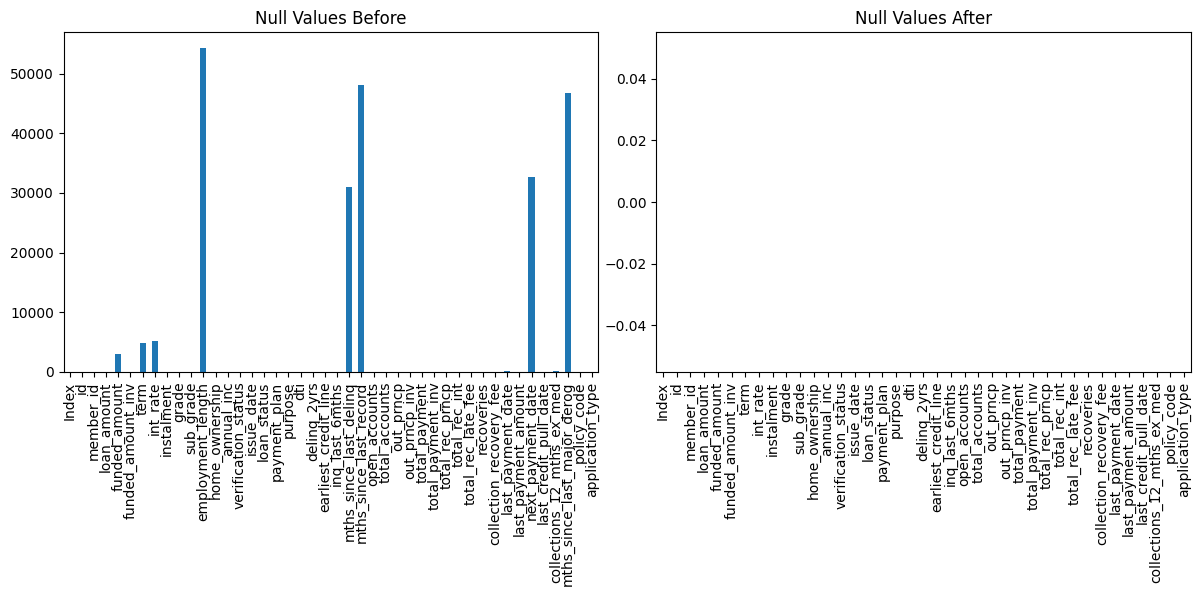

In [6]:
#calls the plotter and visualises the null value removal
nulls_before = dftransformer.count_nulls(dataframe)
dataframe = dftransformer.drop_columns(dataframe, 0.5)
dataframe = dftransformer.impute_columns(dataframe, median_list)
nulls_after = dftransformer.count_nulls(dataframe)

plotter.plot_nulls_before_after(nulls_before, nulls_after)

In [7]:
combined_df = dftransformer.merge_dataframes(dataframe, unskewed_dataframe)
combined_df.to_csv(os.path.join("script_data", "combined_dataframe.csv"), index=False)


In [8]:

plotter.visualise_outliers(dataframe, outlier_columns, False)
before = dataframe
drop_outlier_dictionary = dftransformer.find_closest_outliers(dataframe, outlier_columns)
dataframe = dftransformer.drop_outside_bounds(dataframe, drop_outlier_dictionary)
after = dataframe

{'funded_amount': [-9000.0, 34200.0], 'funded_amount_inv': [-10250.0, 34950.0], 'delinq_2yrs': [0.0, 0.0], 'open_accounts': [-2.0, 22.0], 'total_accounts': [-6.5, 53.5], 'total_payment': [-9672.0, 31840.0], 'total_payment_inv': [-9819.5, 31456.5], 'total_rec_prncp': [-8099.0, 24869.0], 'total_rec_int': [-2761.0, 6975.0], 'last_payment_amount': [-4882.0, 8910.0]}


In [9]:
count_before = dftransformer.calculate_outlier_counts(before, outlier_columns)
count_after = dftransformer.calculate_outlier_counts(after, outlier_columns)
before_dataframe = pd.DataFrame(data = count_before, index = [0])
after_dataframe = pd.DataFrame(data = count_after, index = [0])

columns where I deemed the outliers to be irrelevent to analysing and viewing the dataset as a whole.
        
        funded_amount/inv because there are so little, and too far from median.
        open/total_accounts because it is odd to have 0 accounts open.
        outliers above 5 open accounts seem irrelevent to me as there are so little of them.
        delinq because they are so far from the only value.
        total_payment/inv because the values are too from the median.
        last_payment_amount as the values are too scattered below the lower bounds.

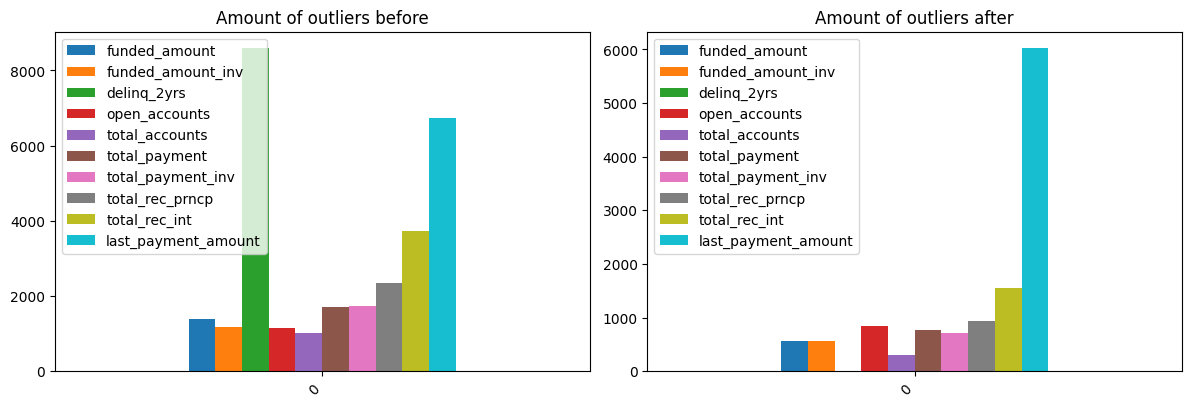

In [10]:
plotter.plot_outliers_before_after(before_dataframe, after_dataframe)

Columns dropped:['id', 'member_id', 'delinq_2yrs', 'funded_amount', 'funded_amount_inv', 'instalment', 'total_payment', 'total_payment_inv', 'total_rec_int', 'out_prncp_inv', 'collection_recovery_fee']


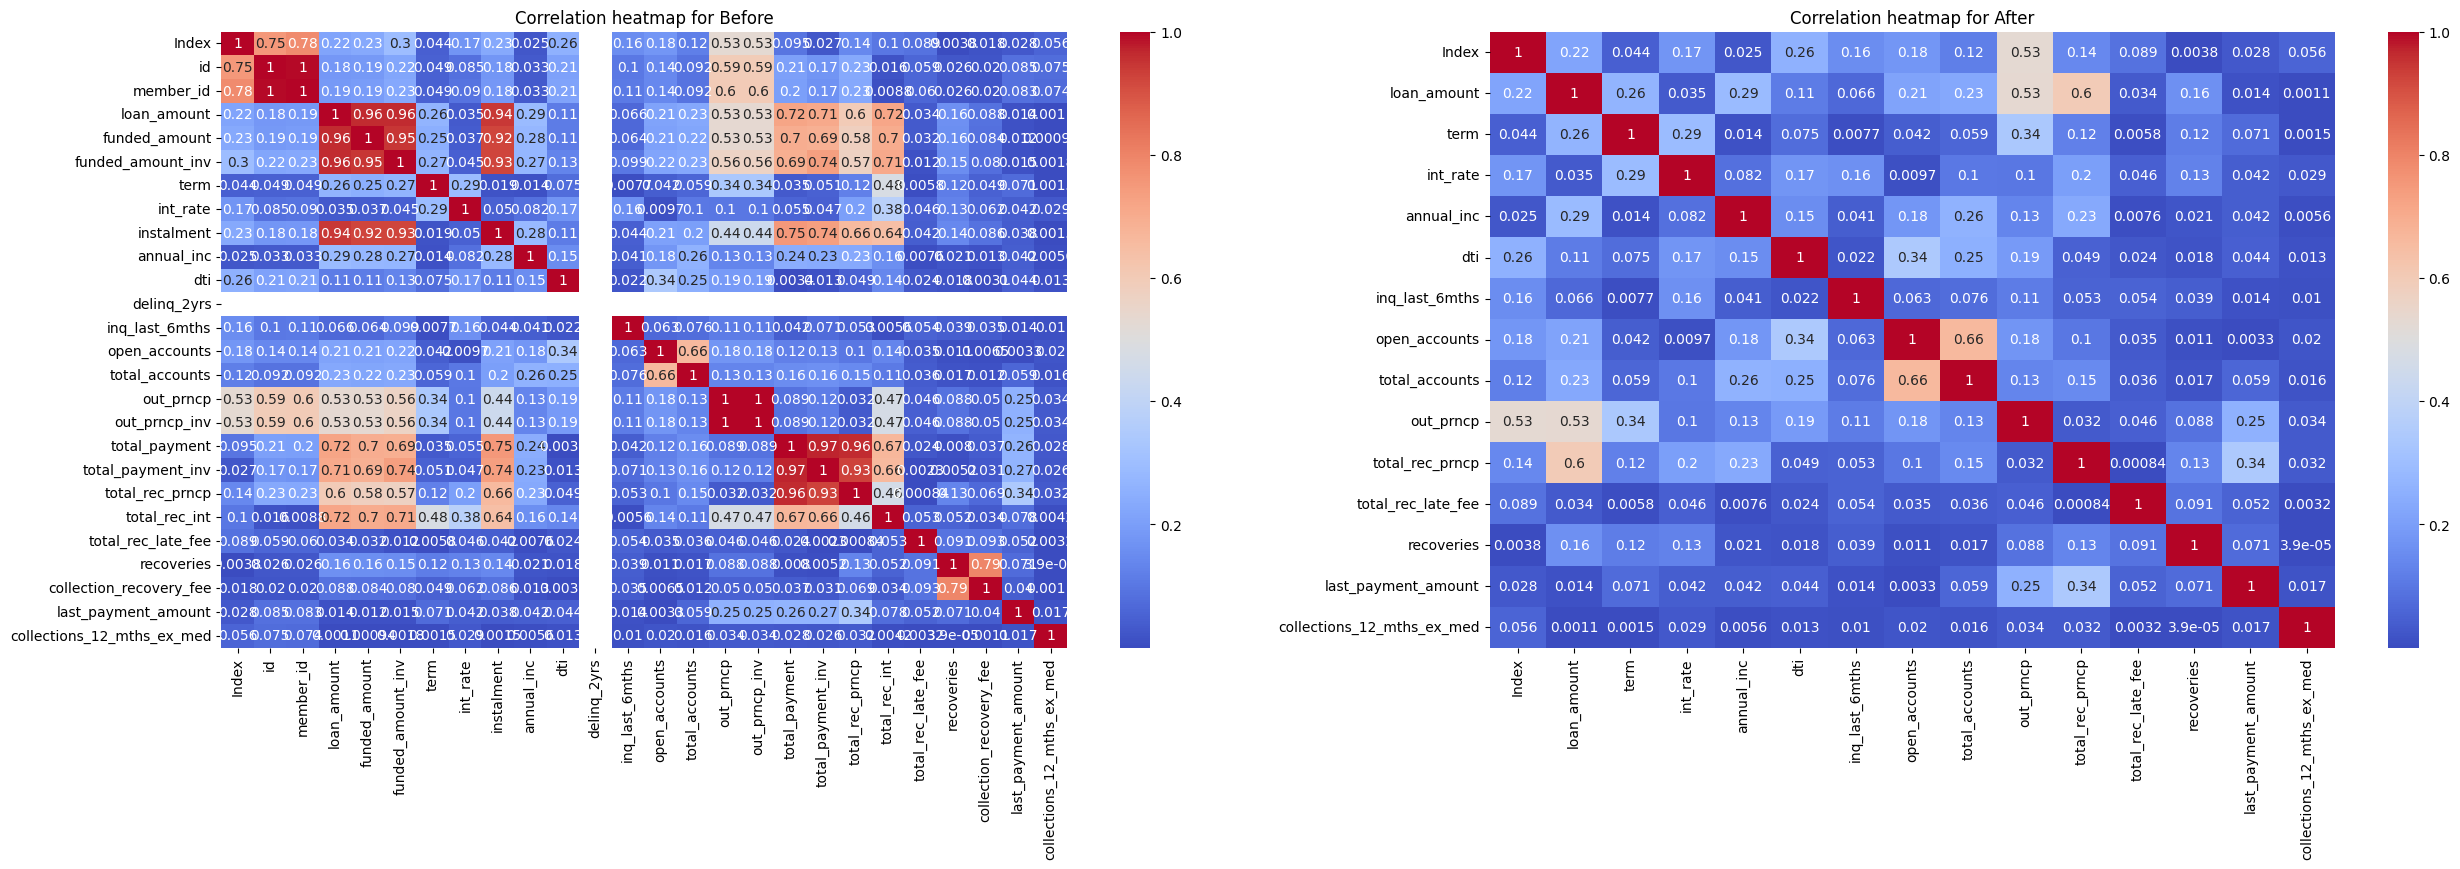

In [11]:
matrix_before = dftransformer.get_correlation_matrix(dataframe)
dataframe = dftransformer.drop_overcorrelated(dataframe, matrix_before)
matrix_after = dftransformer.get_correlation_matrix(dataframe)
plotter.plot_correlation_before_after(matrix_before, matrix_after)

In [ ]:
insights.visualise_repayments(dataframe)

In [ ]:
insights.visualise_loss(dataframe)

In [ ]:
insights.visualise_potential_loss(dataframe)

In [ ]:
insights.indicators_of_loss(dataframe)